# Imports

In [218]:
import openpyxl as px

In [219]:
import numpy as np
import pandas as pd

In [220]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [221]:
from sklearn.linear_model import LinearRegression

In [222]:
from scipy.interpolate import Rbf

# Data

In [223]:
# # parsing the data from the excel file

# file = 'SoilCdataALcottonfield.xlsx'
# wb_obj = px.load_workbook(file, read_only=True, data_only=True)
# sheet_obj = wb_obj.active
# row = sheet_obj.max_row
# column = sheet_obj.max_column

# # column 1, sample ids
# # indexs start at row 14, and are formatted with numbers (location_id) - (sample_id) - (portion_id)
# # position ids are A-F
# # the row after position F is the entire sample
# # the row after the entire sample is the next location

# data = np.zeros((25, 5, 6, 5), dtype=object)
# sample_ids = []
# c_percents = []
# lats = []
# lons = []

# for location_id_row in range(25):
#     lat = sheet_obj.cell(row=location_id_row*35+14, column=2).value
#     lon = sheet_obj.cell(row=location_id_row*35+14, column=3).value
#     for sample_id_row in range(5):
#         for position_id_row in range(6):
#             row = location_id_row*35+sample_id_row*7+14+position_id_row
#             id_val = sheet_obj.cell(row=row, column=1).value
#             c_percent = sheet_obj.cell(row=row, column=8).value
#             sample_ids.append(id_val)
#             c_percents.append(c_percent)
#             data[location_id_row, sample_id_row, position_id_row, 0] = id_val

#             data[location_id_row, sample_id_row, position_id_row, 1] = float(c_percent)
#             data[location_id_row, sample_id_row, position_id_row, 2] = lat
#             data[location_id_row, sample_id_row, position_id_row, 3] = lon

# # this is an index of the depths of the samples
# # A= 0-5; B=5-10; C=10-15; D=15-20; E=20-25; F=25-30
# data[:, :, 0, 4] = -2.5
# data[:, :, 1, 4] = -7.5
# data[:, :, 2, 4] = -12.5
# data[:, :, 3, 4] = -17.5
# data[:, :, 4, 4] = -22.5
# data[:, :, 5, 4] = -27.5

# np.save('soil_data.npy', data)

# df = pd.DataFrame(data.reshape(-1, 5), columns=['id', 'c_percent', 'lat', 'lon', 'alt'])
# df['c_percent'] = df['c_percent'].astype(float)
# df['lat'] = df['lat'].astype(float)
# df['lon'] = df['lon'].astype(float)
# df['alt'] = df['alt'].astype(float)
# df['site'] = np.repeat(np.arange(25), 5*6)
# def sitt(string):
#     return string.split('-')[-1]
# df['site_alt'] = df['site'].astype(str) + '_' + df['id'].apply(sitt).astype(str)
# df['site_alt_id'] = df['id'].apply(sitt).astype(str)

# df.to_csv('soil_data.csv')

In [224]:
data = np.load('soil_data.npy', allow_pickle=True)
data.shape

(25, 5, 6, 5)

In [225]:
df = pd.read_csv('soil_data.csv', index_col=0)
df


id  c_percent        lat        lon   alt  site site_alt site_alt_id
0     1-1-A   1.104222  32.419178 -85.414727  -2.5     0      0_A           A
1     1-1-B   0.475002  32.419178 -85.414727  -7.5     0      0_B           B
2     1-1-C   0.386305  32.419178 -85.414727 -12.5     0      0_C           C
3     1-1-D   0.310593  32.419178 -85.414727 -17.5     0      0_D           D
4     1-1-E   0.333903  32.419178 -85.414727 -22.5     0      0_E           E
..      ...        ...        ...        ...   ...   ...      ...         ...
745  25-5-B   0.579120  32.423816 -85.415641  -7.5    24     24_B           B
746  25-5-C   0.620252  32.423816 -85.415641 -12.5    24     24_C           C
747  25-5-D   0.372506  32.423816 -85.415641 -17.5    24     24_D           D
748  25-5-E   0.058559  32.423816 -85.415641 -22.5    24     24_E           E
749  25-5-F   0.207772  32.423816 -85.415641 -27.5    24     24_F           F

[750 rows x 8 columns]

In [226]:
site_stats = df.groupby('site_alt').agg({
    'c_percent': ['mean', 'std', 'min', 'max'],
    'lat': 'first',
    'lon': 'first',
    'alt': 'first',
    'site_alt_id': 'first'
}).reset_index()
site_stats.columns = ['site', 'c_percent_mean', 'c_percent_std', 'c_percent_min', 'c_percent_max', 'lat', 'lon', 'alt', 'site_alt_id']

In [227]:
a_site_stats = site_stats[site_stats['site_alt_id'] == 'A']

In [228]:
df['depth'] = df['alt'].apply(lambda x: float(-x))

In [229]:
df

id  c_percent        lat        lon   alt  site site_alt site_alt_id  \
0     1-1-A   1.104222  32.419178 -85.414727  -2.5     0      0_A           A   
1     1-1-B   0.475002  32.419178 -85.414727  -7.5     0      0_B           B   
2     1-1-C   0.386305  32.419178 -85.414727 -12.5     0      0_C           C   
3     1-1-D   0.310593  32.419178 -85.414727 -17.5     0      0_D           D   
4     1-1-E   0.333903  32.419178 -85.414727 -22.5     0      0_E           E   
..      ...        ...        ...        ...   ...   ...      ...         ...   
745  25-5-B   0.579120  32.423816 -85.415641  -7.5    24     24_B           B   
746  25-5-C   0.620252  32.423816 -85.415641 -12.5    24     24_C           C   
747  25-5-D   0.372506  32.423816 -85.415641 -17.5    24     24_D           D   
748  25-5-E   0.058559  32.423816 -85.415641 -22.5    24     24_E           E   
749  25-5-F   0.207772  32.423816 -85.415641 -27.5    24     24_F           F   

     depth  
0      2.5  
1      7.5  
2     12.5  
3     17.5  
4     22.5  
..     ...  
745    7.5  
746   12.5  
747   17.5  
748   22.5  
749   27.5  

[750 rows x 9 columns]

In [230]:
site_stats

site  c_percent_mean  c_percent_std  c_percent_min  c_percent_max  \
0    0_A        0.759183       0.202864       0.564546       1.104222   
1    0_B        0.399184       0.055245       0.358526       0.475002   
2    0_C        0.396658       0.068295       0.320139       0.468539   
3    0_D        0.327897       0.119934       0.147849       0.446639   
4    0_E        0.289437       0.173208       0.097421       0.496263   
..   ...             ...            ...            ...            ...   
145  9_B        0.585546       0.163796       0.304759       0.719464   
146  9_C        0.455923       0.125591       0.322285       0.647225   
147  9_D        0.429216       0.118666       0.260586       0.588530   
148  9_E        0.326836       0.137443       0.166724       0.505081   
149  9_F        0.258171       0.082527       0.134552       0.350834   

           lat        lon   alt site_alt_id  
0    32.419178 -85.414727  -2.5           A  
1    32.419178 -85.414727  -7.5           B  
2    32.419178 -85.414727 -12.5           C  
3    32.419178 -85.414727 -17.5           D  
4    32.419178 -85.414727 -22.5           E  
..         ...        ...   ...         ...  
145  32.419811 -85.416027  -7.5           B  
146  32.419811 -85.416027 -12.5           C  
147  32.419811 -85.416027 -17.5           D  
148  32.419811 -85.416027 -22.5           E  
149  32.419811 -85.416027 -27.5           F  

[150 rows x 9 columns]

In [231]:
a_site_stats

site  c_percent_mean  c_percent_std  c_percent_min  c_percent_max  \
0     0_A        0.759183       0.202864       0.564546       1.104222   
6    10_A        0.656695       0.201121       0.470259       0.964967   
12   11_A        0.948865       0.383564       0.627369       1.596885   
18   12_A        0.954124       0.193109       0.804027       1.267367   
24   13_A        0.642784       0.145905       0.424855       0.822481   
30   14_A        0.868540       0.141591       0.671202       0.999615   
36   15_A        0.953590       0.205384       0.673621       1.161161   
42   16_A        0.719580       0.145019       0.559687       0.893513   
48   17_A        0.866636       0.146379       0.661137       1.042919   
54   18_A        0.786524       0.152202       0.606043       0.986294   
60   19_A        0.846623       0.365678       0.452759       1.272926   
66    1_A        0.843667       0.142219       0.630993       0.992811   
72   20_A        0.850294       0.298324       0.504524       1.243861   
78   21_A        0.640769       0.110447       0.523671       0.802358   
84   22_A        0.896896       0.343703       0.414335       1.246204   
90   23_A        0.855168       0.279384       0.398265       1.125444   
96   24_A        0.725523       0.152456       0.479043       0.873824   
102   2_A        1.018786       0.455488       0.510085       1.548026   
108   3_A        1.053320       0.273959       0.629143       1.361320   
114   4_A        0.675044       0.180372       0.502954       0.872182   
120   5_A        1.148318       0.354650       0.787538       1.625121   
126   6_A        0.692486       0.338280       0.094418       0.899260   
132   7_A        0.881314       0.303662       0.572655       1.239831   
138   8_A        1.017481       0.388003       0.616903       1.655012   
144   9_A        1.062312       0.288427       0.692031       1.311199   

           lat        lon  alt site_alt_id  
0    32.419178 -85.414727 -2.5           A  
6    32.420261 -85.413971 -2.5           A  
12   32.419891 -85.414952 -2.5           A  
18   32.424191 -85.418357 -2.5           A  
24   32.423233 -85.417794 -2.5           A  
30   32.422263 -85.417299 -2.5           A  
36   32.421338 -85.416801 -2.5           A  
42   32.420978 -85.416095 -2.5           A  
48   32.423318 -85.416880 -2.5           A  
54   32.422333 -85.416391 -2.5           A  
60   32.424147 -85.417057 -2.5           A  
66   32.418902 -85.413783 -2.5           A  
72   32.421784 -85.415659 -2.5           A  
78   32.423211 -85.415897 -2.5           A  
84   32.422599 -85.415121 -2.5           A  
90   32.421618 -85.414716 -2.5           A  
96   32.423816 -85.415641 -2.5           A  
102  32.418566 -85.412972 -2.5           A  
108  32.418692 -85.412371 -2.5           A  
114  32.419578 -85.413746 -2.5           A  
120  32.419375 -85.413048 -2.5           A  
126  32.420871 -85.413804 -2.5           A  
132  32.420644 -85.414877 -2.5           A  
138  32.420276 -85.415817 -2.5           A  
144  32.419811 -85.416027 -2.5           A

# Data Inspection

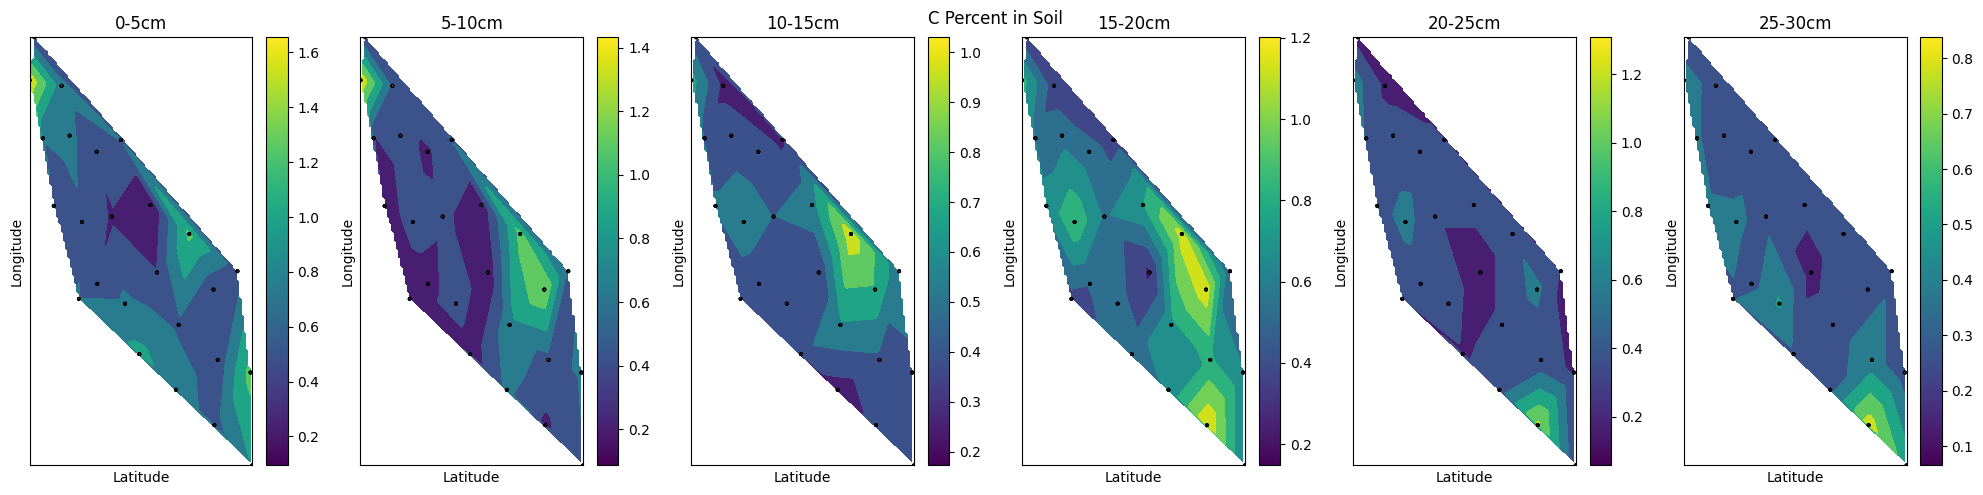

In [232]:
# layer = 0
n_layer = data.shape[2]
layer_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30']

fig, ax = plt.subplots(1, n_layer, figsize=(20, 5))
for layer in range(n_layer):
    z = data[:, :, layer, 1].astype(float).flatten()
    x = data[:, :, layer, 2].astype(float).flatten()
    y = data[:, :, layer, 3].astype(float).flatten()
    npts = 125
    ngridx = 100
    ngridy = 200
    xi = np.linspace(x.min(), x.max(), ngridx)
    yi = np.linspace(y.min(), y.max(), ngridy)
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z, trifinder=triang.get_trifinder())
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax[layer].set_title(layer_labels[layer]+'cm')
    ax[layer].set_xlim(x.min(), x.max())
    ax[layer].set_xticks([])
    ax[layer].set_ylim(y.min(), y.max())
    ax[layer].set_yticks([])
    ax[layer].set_xlabel('Latitude')
    ax[layer].set_ylabel('Longitude')
    ax[layer].contourf(xi, yi, zi, levels=5)
    # ax[layer].contour(xi, yi, zi, levels=100, linewidths=0.5)
    fig.colorbar(ax[layer].scatter(x, y, c=z, s=3, edgecolors='k'), ax=ax[layer])
fig.tight_layout()
fig.suptitle('C Percent in Soil')
plt.show()

In [233]:
data.shape

(25, 5, 6, 5)

In [234]:
lowest = np.min(np.min(data[:, :, :, 1], axis=-1), axis=-1)
highest = np.max(np.max(data[:, :, :, 1], axis=-1), axis=-1)

In [235]:
from scipy.interpolate import Rbf


In [236]:
rbf = Rbf(data[:, 0, 0, 2].astype(float), data[:, 0, 0, 3].astype(float), lowest.astype(float), function='linear')

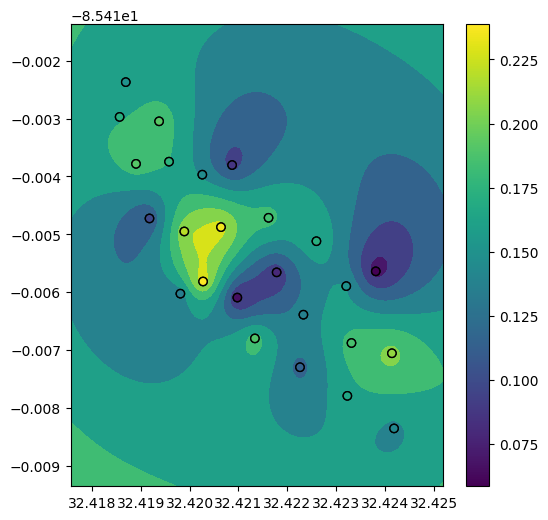

In [237]:
pad = 0.001
xi = np.linspace(data[:, 0, 0, 2].astype(float).min()-pad, data[:, 0, 0, 2].astype(float).max()+pad, 100)
yi = np.linspace(data[:, 0, 0, 3].astype(float).min()-pad, data[:, 0, 0, 3].astype(float).max()+pad, 100)
xi, yi = np.meshgrid(xi, yi)
zi = rbf(xi, yi)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.contourf(xi, yi, zi)
# draw the points
ax.scatter(data[:, 0, 0, 2].astype(float), data[:, 0, 0, 3].astype(float), c=lowest.astype(float), edgecolors='k')
fig.colorbar(ax.scatter(data[:, 0, 0, 2].astype(float), data[:, 0, 0, 3].astype(float), c=lowest.astype(float), edgecolors='k'), ax=ax)


plt.xlim(data[:, 0, 0, 2].astype(float).min()-pad, data[:, 0, 0, 2].astype(float).max()+pad)
plt.ylim(data[:, 0, 0, 3].astype(float).min()-pad, data[:, 0, 0, 3].astype(float).max()+pad)
plt.show()

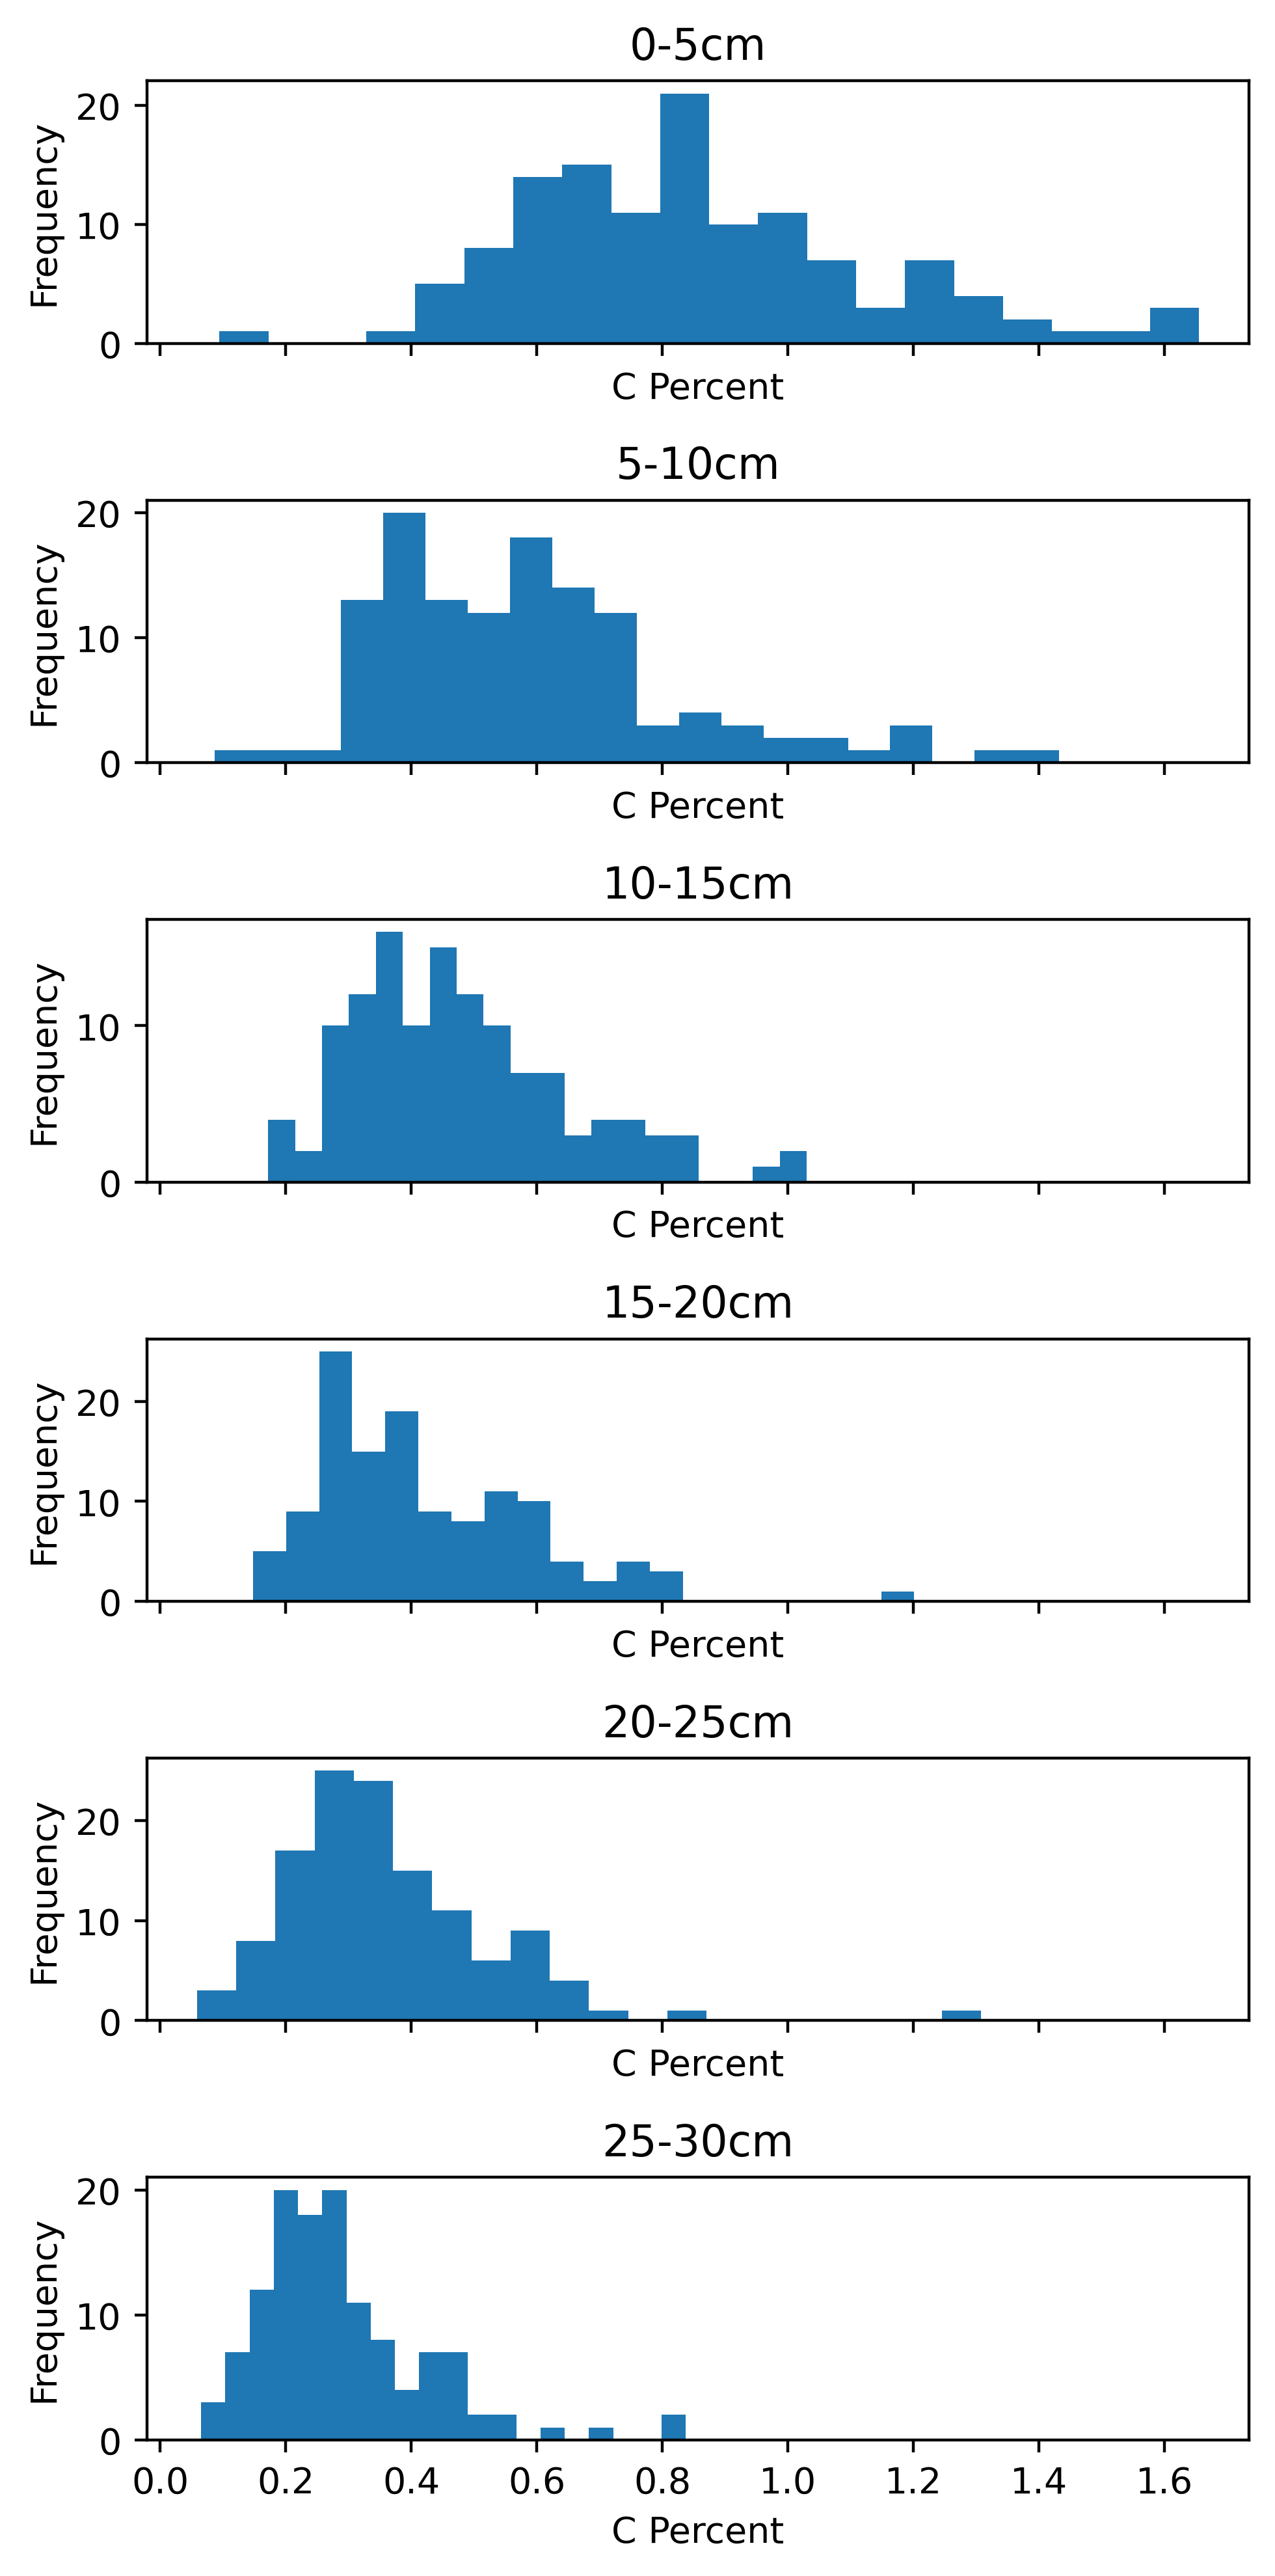

In [238]:
n_layer = data.shape[2]
layer_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30']
fig, ax = plt.subplots(n_layer, 1, figsize=(5, 10), sharex=True, dpi=400)

for layer in range(n_layer):
    ax[layer].hist(data[:, :, layer, 1].flatten(), bins=20)
    ax[layer].set_title(layer_labels[layer]+'cm')
    ax[layer].set_xlabel('C Percent')
    ax[layer].set_ylabel('Frequency')
fig.tight_layout()
# fig.suptitle('C Percent in Soil')
plt.show()

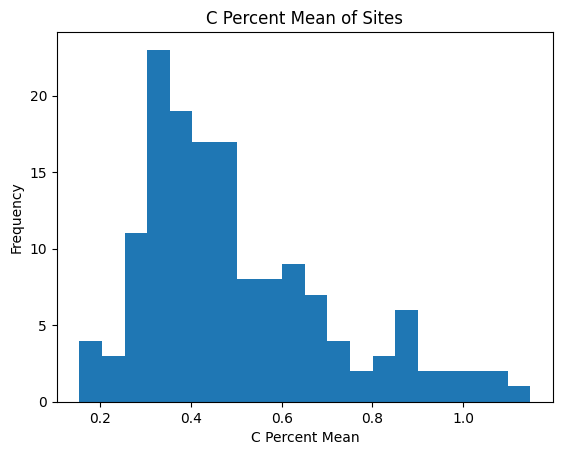

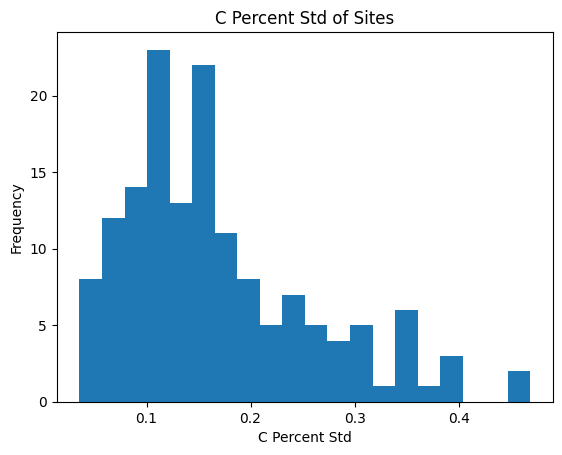

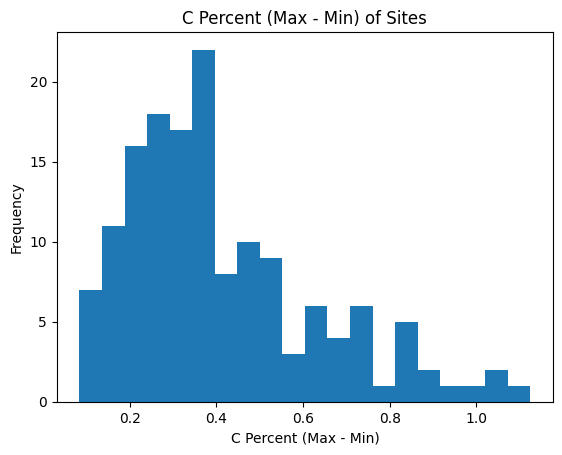

In [239]:
# graph hist of c_percent_mean
plt.hist(site_stats['c_percent_mean'], bins=20)
plt.xlabel('C Percent Mean')
plt.ylabel('Frequency')
plt.title('C Percent Mean of Sites')
plt.show()

# graph hist of c_percent_std
plt.hist(site_stats['c_percent_std'], bins=20)
plt.xlabel('C Percent Std')
plt.ylabel('Frequency')
plt.title('C Percent Std of Sites')
plt.show()

plt.hist(site_stats['c_percent_max'] - site_stats['c_percent_min'], bins=20)
plt.xlabel('C Percent (Max - Min)')
plt.ylabel('Frequency')
plt.title('C Percent (Max - Min) of Sites')
plt.show()


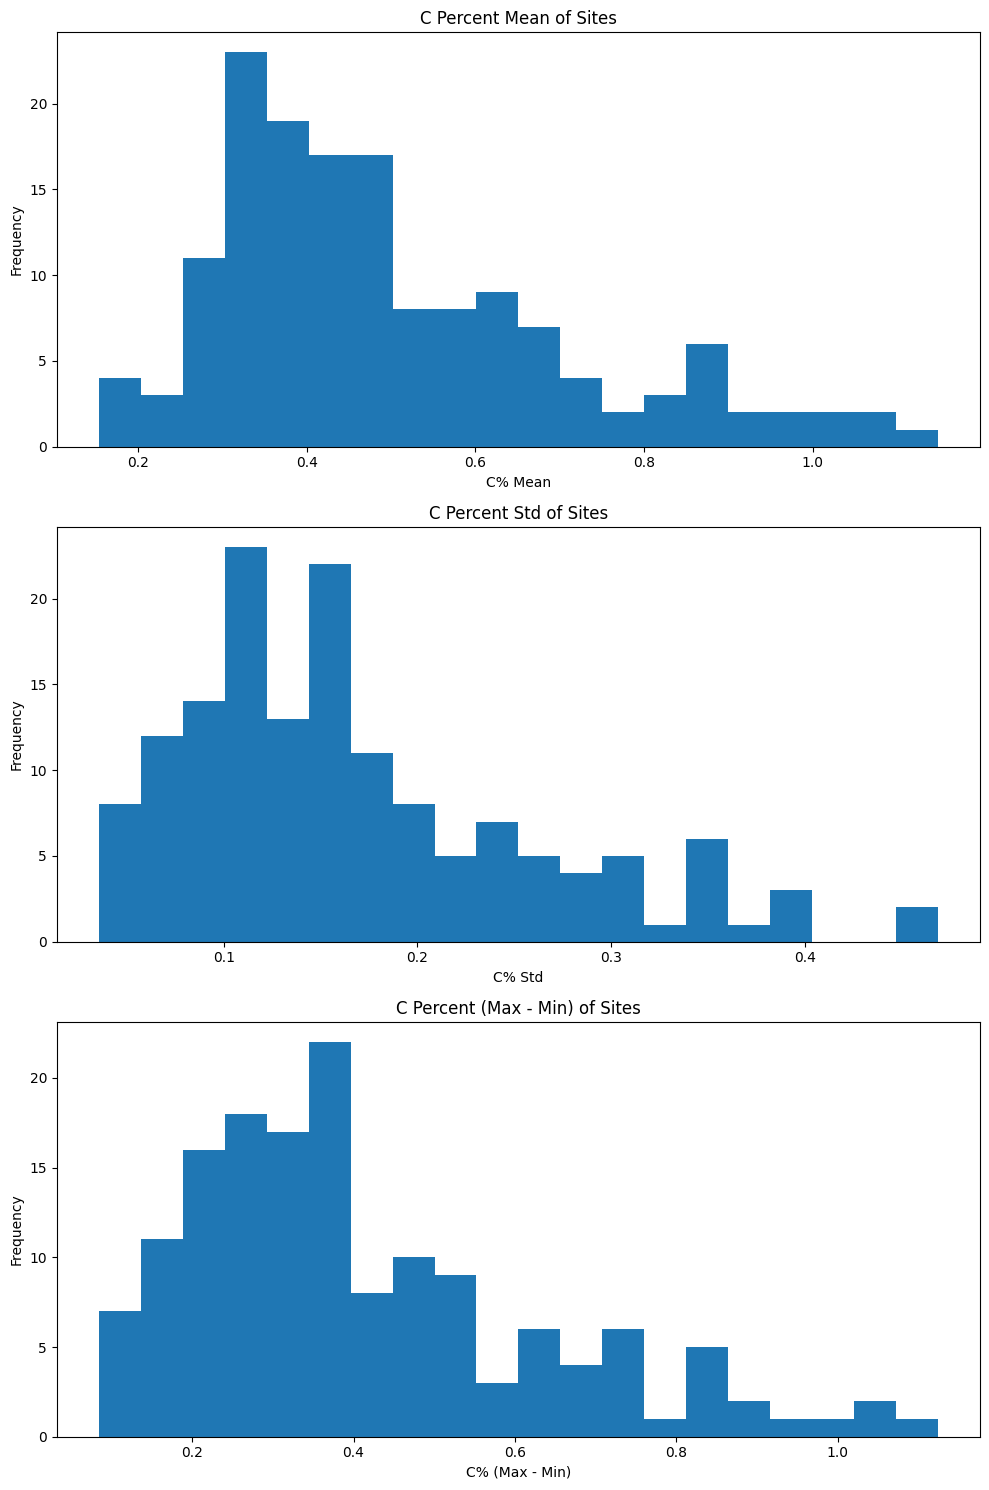

In [240]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# graph hist of c_percent_mean
ax[0].hist(site_stats['c_percent_mean'], bins=20)
ax[0].set_xlabel('C% Mean')
ax[0].set_ylabel('Frequency')
ax[0].set_title('C Percent Mean of Sites')

# graph hist of c_percent_std
ax[1].hist(site_stats['c_percent_std'], bins=20)
ax[1].set_xlabel('C% Std')
ax[1].set_ylabel('Frequency')
ax[1].set_title('C Percent Std of Sites')

# graph hist of c_percent_max - c_percent_min
ax[2].hist(site_stats['c_percent_max'] - site_stats['c_percent_min'], bins=20)
ax[2].set_xlabel('C% (Max - Min)')
ax[2].set_ylabel('Frequency')
ax[2].set_title('C Percent (Max - Min) of Sites')

plt.tight_layout()
plt.show()


In [241]:
# core:
# 	30 inch rod used to harvest soil
# trial:
# 	5 cores are harvested at each location
# cylinder:
# 	6 vertical sections of the core, each 5 inch length that are individually tested

# An explination of graph:

# Contour plots are used to graph the amounts of carbon found in a field from core sampling.
# These plots are generated from the top cylinders from the cores.
# The left plot is generated from the average of the harvested samples, the middle by picking the lowest, then highest on the right.

# suptitle = 'C Percent in Soil (Top Cylinder) by Sample (Average, Lowest, Highest)'

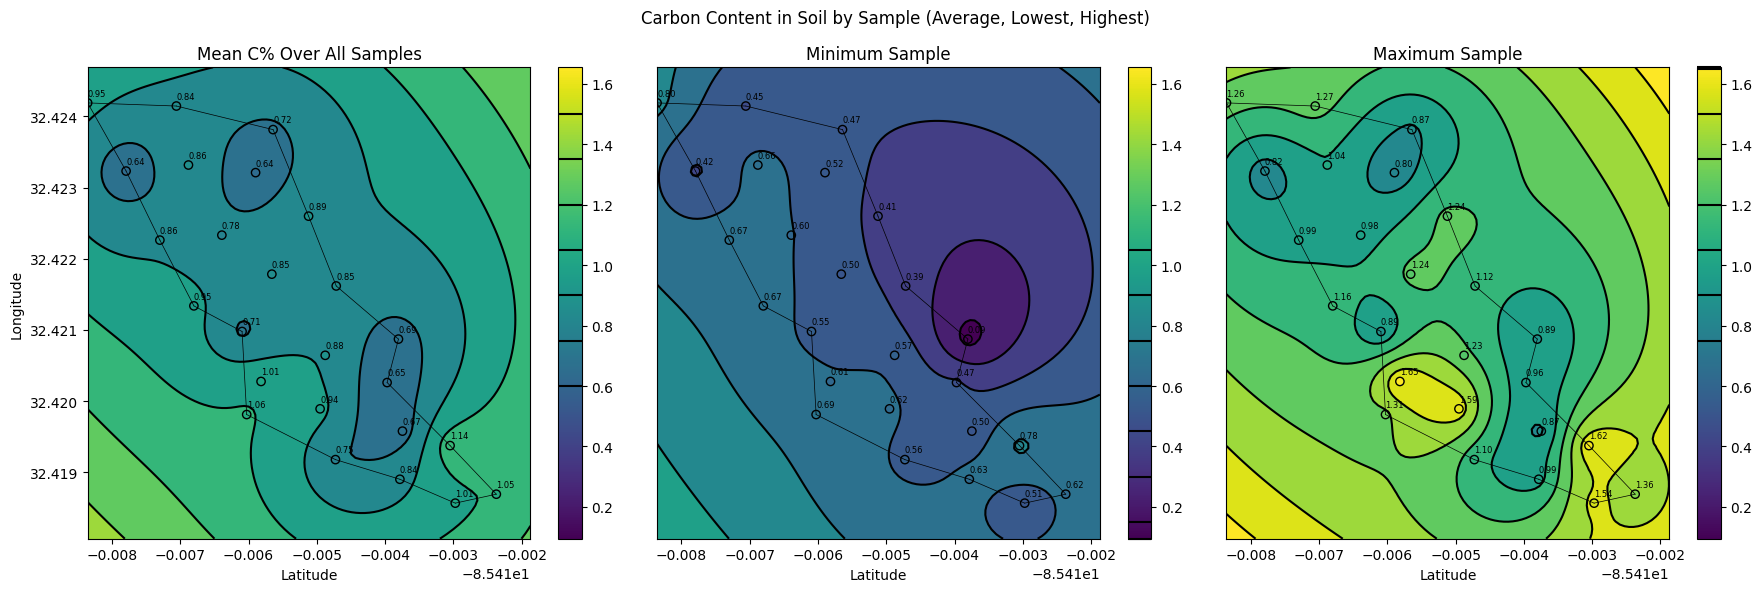

In [242]:
# make the contour plot of the c_percent_mean, c_percent_min, c_percent_max
# different layout options: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, ax = plt.subplots(1, 3, figsize=(18, 6), layout='tight')
frame = a_site_stats

y = frame['lat']
x = frame['lon']

cols = ['c_percent_mean', 'c_percent_min', 'c_percent_max']

vmin = frame[cols].min().min()
vmax = frame[cols].max().max()
pad = 0.0005

line_starts = [0, 144, 42, 36, 30, 24, 18, 60, 96, 84, 90, 126, 6, 120, 108, 102, 66]
line_ends = line_starts[1:] + [line_starts[0]]

plot_titles = ['Mean C% Over All Samples','Minimum Sample', 'Maximum Sample']
contours = []
xi = np.linspace(x.min(), x.max() + pad, 100)
yi = np.linspace(y.min() - pad, y.max() + pad, 100)

for i, col in enumerate(cols):
    rbf = Rbf(x.to_numpy().astype(float), y.to_numpy().astype(float), frame[col].to_numpy().astype(float), function='linear')
    
    Xi, Yi = np.meshgrid(xi, yi)
    zi = rbf(Xi, Yi)
    
    contourf = ax[i].contourf(Xi, Yi, zi, levels=6, cmap='viridis', vmin=vmin, vmax=vmax)
    contour = ax[i].contour(contourf, colors='k')

    scatter = ax[i].scatter(x, y, c=frame[col], edgecolors='k', cmap='viridis', vmin=vmin, vmax=vmax)
    bar = fig.colorbar(scatter, ax=ax[i])
    bar.add_lines(contour)
    ax[i].set_title(plot_titles[i])

    # label the points
    for j, txt in enumerate(frame[col]):
        ax[i].annotate(str(txt)[:4], (x.iloc[j], y.iloc[j]+.0001), fontsize=6)
    
    # draw the lines
    for start, end in zip(line_starts, line_ends):
        ax[i].plot(x.loc[[start, end]], y.loc[[start, end]], 'k-', linewidth=0.5)
    
    ax[i].set_xlabel('Latitude')
    # ax[i].set_ylabel('Longitude')
    # yticks = ax[i].get_yticks()

    # ax[i].set_yticks(yticks, [])
    # yticks = np.round(yticks, 4)
    if i > 0:
        ax[i].set_yticks([], [])

ax[0].set_ylabel('Longitude')

# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# bar = fig.colorbar(scatter, cax=cbar_ax, label='C %')
# for contour in contours:
#     bar.add_lines(contour)
plt.suptitle('Carbon Content in Soil by Sample (Average, Lowest, Highest)')
plt.show()


# pretty graphs

In [243]:
def dms_to_decimal(degrees, minutes, seconds, direction):
    """
    Convert latitude or longitude from degrees, minutes, and seconds to decimal degrees.
    
    Parameters:
    degrees (int): Degrees part of the coordinate
    minutes (int): Minutes part of the coordinate
    seconds (float): Seconds part of the coordinate
    direction (str): Direction part of the coordinate ('N', 'S', 'E', 'W')
    
    Returns:
    float: Decimal degrees
    """
    decimal = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        decimal = -decimal
    return decimal

# # Example usage:
# latitude = dms_to_decimal(32, 25, 5.4, 'N')
# longitude = dms_to_decimal(85, 25, 12, 'W')
# print(f"Latitude: {latitude}, Longitude: {longitude}")

def decimal_to_dms(decimal, is_latitude=True):
    """
    Convert decimal degrees to degrees, minutes, and seconds.
    
    Parameters:
    decimal (float): Decimal degrees
    is_latitude (bool): True if the coordinate is latitude, False if longitude
    
    Returns:
    tuple: Degrees, minutes, seconds, direction
    """
    degrees = int(decimal)
    minutes = int((decimal - degrees) * 60)
    seconds = (decimal - degrees - minutes / 60) * 3600
    direction = 'N' if is_latitude else 'E'
    if decimal < 0:
        direction = 'S' if is_latitude else 'W'
        degrees = -degrees
    return degrees, minutes, seconds, direction

# # Example usage:
# lat_dms = decimal_to_dms(latitude, is_latitude=True)
# lon_dms = decimal_to_dms(longitude, is_latitude=False)
# print(f"Latitude DMS: {lat_dms}, Longitude DMS: {lon_dms}")

In [244]:
# imshow for feild/background.png

# pixel - lat (N) - lon (W)
# 962, 1267 - 32, 24, 58 - 85, 24, 38
# 102, 1267 - 32, 24, 58 - 85, 25, 12
# 102, 125 - 32, 25, 35 - 85, 25, 12
# 962, 125 - 32, 25, 35 - 85, 24, 38 

# W / x
# 102; 85, 25, 12; -85.42000000000002
# 962; 85, 24, 38; -85.41055555555556 

# N / y
# 125; 32, 25, 35; 32.41611111111111
# 1267; 32, 24, 58; 32.42638888888889

# use linear regression to find the lat, lon of the pixel 0, 0


In [245]:
# imshow for feild/background.png
figsize = (10.68*3, 14.14)
dpi = 100 #100 default
resolution = (int(figsize[0]*dpi), int(figsize[1]*dpi))

model = LinearRegression()

model.fit(np.array([[125, 1267]]), np.array([[32.41611111111111, 32.42638888888889]]))
bottom, top = model.predict(np.array([[0, resolution[0]]]))[0]
model = LinearRegression()
model.fit(np.array([[102, 962]]), np.array([[-85.42000000000002, -85.41055555555556]]))
left, right = model.predict(np.array([[0, resolution[1]]]))[0]

In [246]:
df

id  c_percent        lat        lon   alt  site site_alt site_alt_id  \
0     1-1-A   1.104222  32.419178 -85.414727  -2.5     0      0_A           A   
1     1-1-B   0.475002  32.419178 -85.414727  -7.5     0      0_B           B   
2     1-1-C   0.386305  32.419178 -85.414727 -12.5     0      0_C           C   
3     1-1-D   0.310593  32.419178 -85.414727 -17.5     0      0_D           D   
4     1-1-E   0.333903  32.419178 -85.414727 -22.5     0      0_E           E   
..      ...        ...        ...        ...   ...   ...      ...         ...   
745  25-5-B   0.579120  32.423816 -85.415641  -7.5    24     24_B           B   
746  25-5-C   0.620252  32.423816 -85.415641 -12.5    24     24_C           C   
747  25-5-D   0.372506  32.423816 -85.415641 -17.5    24     24_D           D   
748  25-5-E   0.058559  32.423816 -85.415641 -22.5    24     24_E           E   
749  25-5-F   0.207772  32.423816 -85.415641 -27.5    24     24_F           F   

     depth  
0      2.5  
1      7.5  
2     12.5  
3     17.5  
4     22.5  
..     ...  
745    7.5  
746   12.5  
747   17.5  
748   22.5  
749   27.5  

[750 rows x 9 columns]

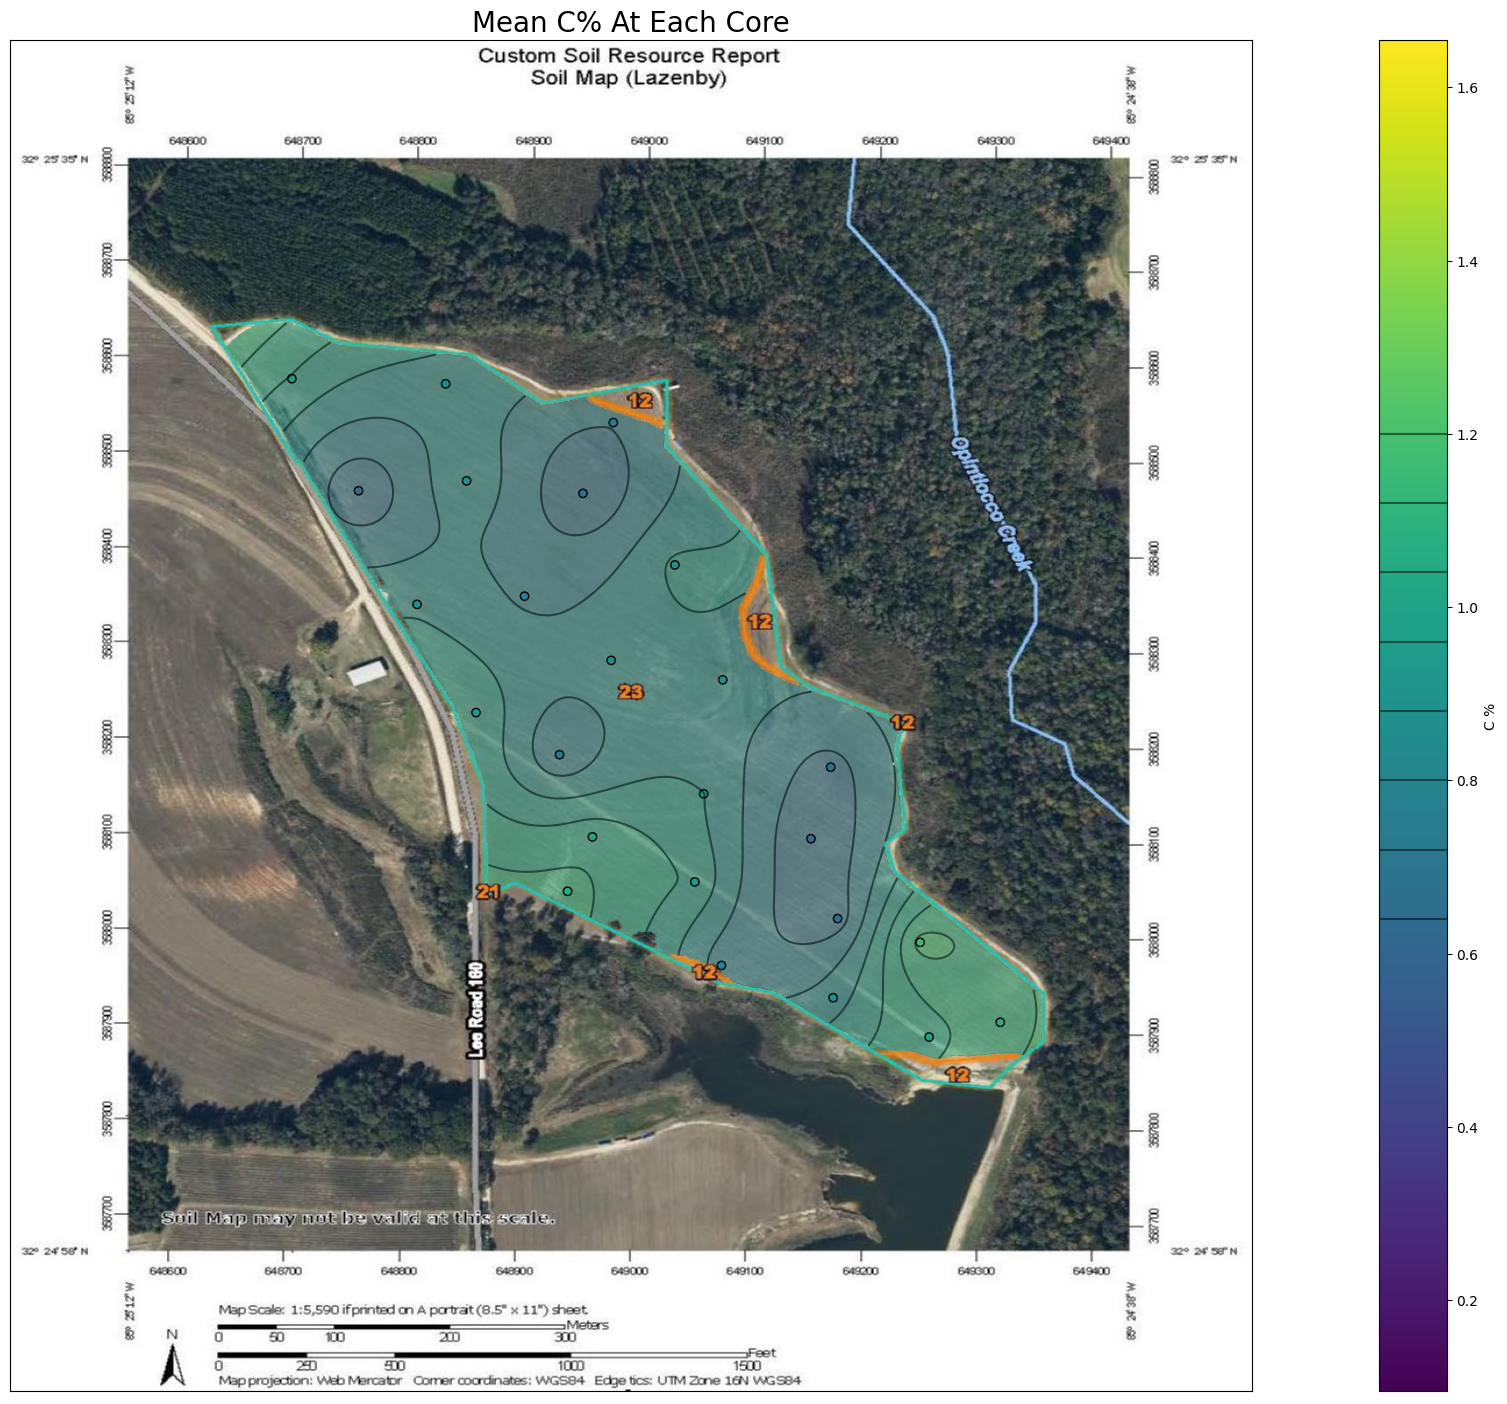

In [247]:
mask = plt.imread('feild/feild.png')[::-1][:, :, -1].astype(bool)

cols = ['c_percent_mean']
plot_titles = ['Mean C% At Each Core']

fig, ax = plt.subplots(1, len(cols), figsize=figsize, dpi=dpi)
# force ax to be [[ax]] if len(cols) == 1
if len(cols) == 1:
    ax = np.array([ax])


xi = np.linspace(left, right, 1068)
yi = np.linspace(bottom, top, 1414)

x = frame['lon'].to_numpy().astype(float)
y = frame['lat'].to_numpy().astype(float)

min_x = x.min()
x = x - min_x
x = x*0.9
x = x + min_x
x+=0.0005

min_y = y.min()
y = y - min_y
y = y*0.89
y = y + min_y
y+=0.00024

i = 0
col='c_percent_mean'
z = frame[col].to_numpy().astype(float)
rbf = Rbf(x, y, z, function='linear')
Xi, Yi = np.meshgrid(xi, yi)
zi = rbf(Xi, Yi)
zi = np.ma.array(zi, mask=~mask)
ax[i].imshow(plt.imread('feild/feild.png'), alpha=1, extent=[left, right, bottom, top])
ax[i].contourf(Xi, Yi, zi, levels=6, cmap='viridis', vmin=vmin, vmax=vmax, alpha=.5)
contour = ax[i].contour(Xi, Yi, zi, levels=6, colors='k', alpha=0.5)
# ax[i].imshow(plt.imread('feild/feild.png'), alpha=1, extent=[left, right, bottom, top])
scatter = ax[i].scatter(x, y, c=z, edgecolors='k', cmap='viridis', vmin=vmin, vmax=vmax)
ax[i].imshow(plt.imread('feild/background.png'), alpha=1, extent=[left, right, bottom, top])
ax[i].set_xticks([])
ax[i].set_yticks([])
# ax[i].set_title(plot_titles[i], fontsize=2)

# make colorbar smaller
bar = fig.colorbar(scatter, ax=ax[i], fraction=0.046, pad=0.04, label='C %')
bar.add_lines(contour)
ax[i].set_title(plot_titles[i], fontsize=20)

# draw lines at maximum and minimum carbon levels from df
_max = df.c_percent.max()
_min = df.c_percent.min()
bar.ax.axhline(_max, color='r', linestyle='--', label='Max C%')
bar.ax.axhline(_min, color='b', linestyle='--', label='Min C%')

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('../../Figures/CaseStudy/fieldstudy.png', dpi=dpi, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2062348/3534909524.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


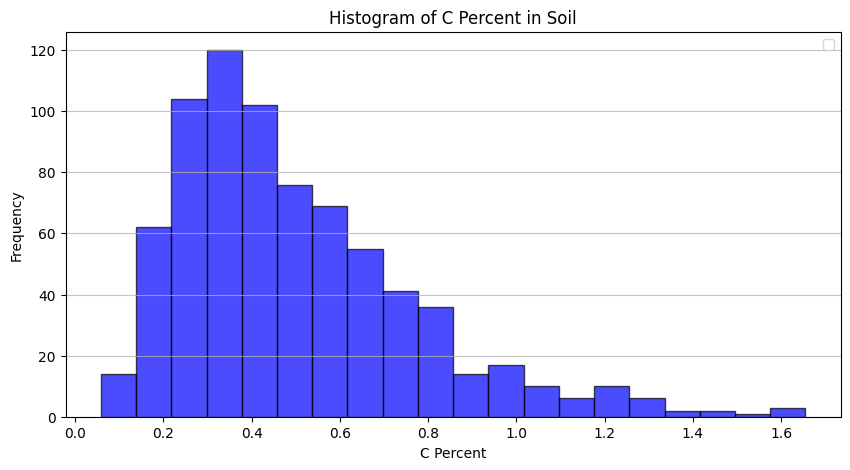

In [248]:
plt.figure(figsize=(10, 5))
plt.hist(df['c_percent'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of C Percent in Soil')
plt.xlabel('C Percent')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

/tmp/ipykernel_2062348/3884721566.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['c_percent'][df['depth'] == alt] for alt in sorted(df['depth'].unique())],


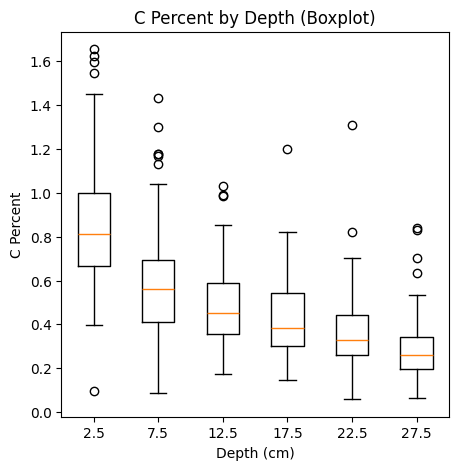

In [249]:
plt.figure(figsize=(5, 5))
plt.boxplot([df['c_percent'][df['depth'] == alt] for alt in sorted(df['depth'].unique())],
            labels=[str(alt) for alt in sorted(df['depth'].unique())])
plt.xlabel('Depth (cm)')
plt.ylabel('C Percent')
plt.title('C Percent by Depth (Boxplot)')
plt.show()


/tmp/ipykernel_2062348/1279707878.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs['boxplot'].boxplot([df['c_percent'][df['depth'] == alt] for alt in sorted(df['depth'].unique())],


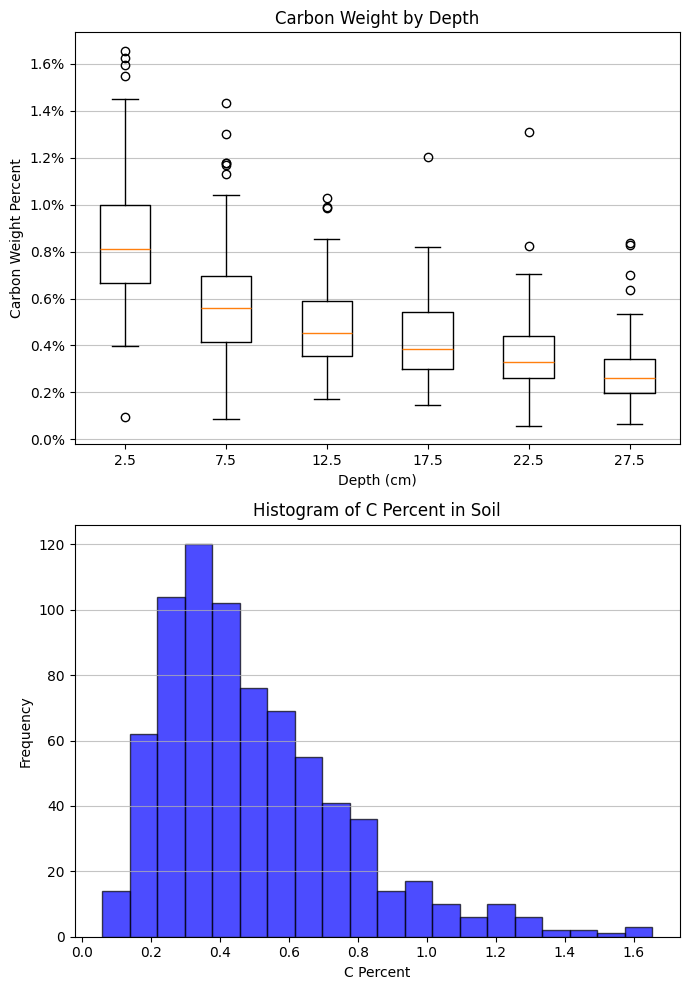

In [250]:
# fig, axs = plt.subplots(1, 3, figsize=(24, 7), dpi=dpi)

fig, axs = plt.subplot_mosaic(
    [
        ['boxplot'],
        ['histogram']
    ],
    figsize=(7, 10),
    dpi=dpi,
)

# 2. Histogram
axs['histogram'].hist(df['c_percent'], bins=20, color='blue', alpha=0.7, edgecolor='black')
axs['histogram'].set_title('Histogram of C Percent in Soil')
axs['histogram'].set_xlabel('C Percent')
axs['histogram'].set_ylabel('Frequency')
axs['histogram'].grid(axis='y', alpha=0.75)

# 3. Boxplot
axs['boxplot'].boxplot([df['c_percent'][df['depth'] == alt] for alt in sorted(df['depth'].unique())],
               labels=[str(alt) for alt in sorted(df['depth'].unique())])
axs['boxplot'].set_xlabel('Depth (cm)')
axs['boxplot'].set_ylabel('Carbon Weight Percent')
axs['boxplot'].set_title('Carbon Weight by Depth')
# put a percent symbol on the y-axis
axs['boxplot'].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
axs['boxplot'].grid(axis='y', alpha=0.75)

plt.tight_layout()
# save to fieldstudy.png
plt.savefig('../../Figures/CaseStudy/depthstudy.png', dpi=dpi, bbox_inches='tight')
plt.show()


In [263]:
_desc = df.c_percent.describe()
print(_desc)

count    750.000000
mean       0.499261
std        0.271092
min        0.058559
25%        0.301823
50%        0.429320
75%        0.634832
max        1.655012
Name: c_percent, dtype: float64


In [251]:
left

np.float64(-85.42000000000002)

In [252]:
right

np.float64(-85.41055555555556)

In [253]:
top, bottom

(np.float64(32.42638888888889), np.float64(32.41611111111111))

In [254]:
figsize = (6.13*3, 7.83)
dpi = 100 #100 default
resolution = (int(figsize[0]*dpi), int(figsize[1]*dpi))

# px x, y = (lat, lon)
# px 111, 114 = (85, 25, 5, W) (32, 25, 30, N) coords, 
# px 111, 727 = (85, 25, 5, W) (32, 25, 0, N) coords
# px 520, 114 = (85, 24, 45, W) (32, 25, 30, N) coords 
# px 520, 727 = (85, 24, 45, W) (32, 25, 0, N) coords

In [255]:
y0 = 114
y1 = 727
f_y0 = dms_to_decimal(32, 25, 30, 'N')
f_y1 = dms_to_decimal(32, 25, 0, 'N')
y0, y1, f_y0, f_y1

(114, 727, 32.425, 32.416666666666664)

In [256]:
def ylinreg(y):
    return (f_y1-f_y0)/(y1-y0)*(y-y0)+f_y0

In [257]:
x0 = 111
x1 = 520
f_x0 = dms_to_decimal(85, 25, 5, 'W')
f_x1 = dms_to_decimal(85, 24, 45, 'W')
x0, x1, f_x0, f_x1

(111, 520, -85.41805555555555, -85.41250000000001)

In [258]:
def xlinreg(x):
    return (f_x1-f_x0)/(x1-x0)*(x-x0)+f_x0

In [259]:
bottom, top = ylinreg(resolution[1]), ylinreg(0)

In [260]:
left, right = xlinreg(0), xlinreg(resolution[0]/3)

0.0 0.00562501048820252
0.0 0.00562501048820252


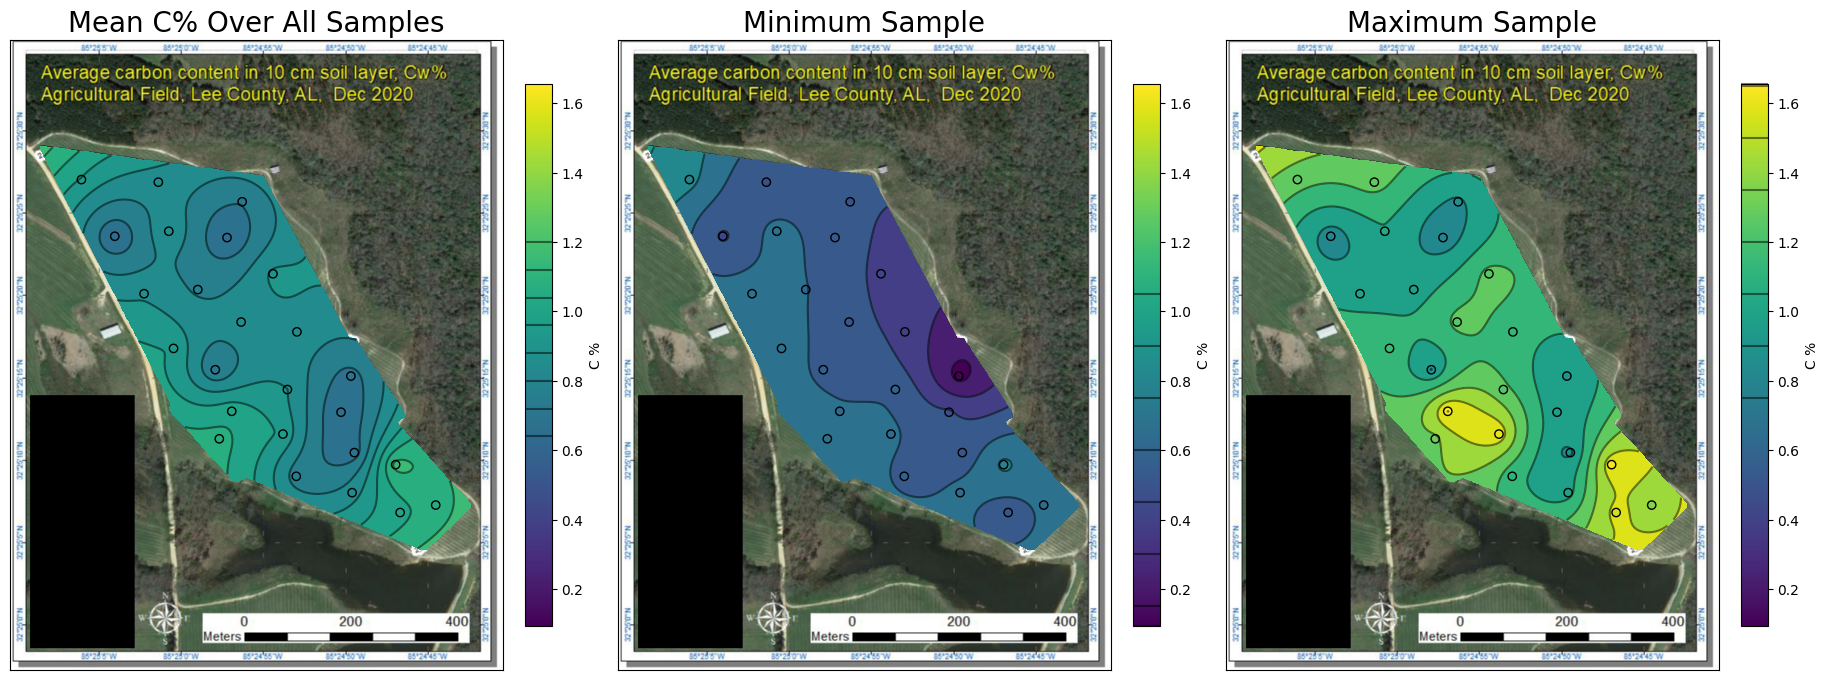

In [261]:
mask = plt.imread('feild/landalpha.png')[::-1][:, :, -1].astype(bool)

cols = ['c_percent_mean', 'c_percent_min', 'c_percent_max']
plot_titles = ['Mean C% Over All Samples','Minimum Sample', 'Maximum Sample']



xi = np.linspace(left, right, 613)
yi = np.linspace(bottom, top, 783)

x = frame['lon'].to_numpy().astype(float)
y = frame['lat'].to_numpy().astype(float)

min_x = x.min()
x = x - min_x
# x = x*1.1
x = x + min_x
# x+=0.0005

min_y = y.min()
y = y - min_y
print(y.min(), y.max())
# y = y*1.2
print(y.min(), y.max())
y = y + min_y
# y+=0.00024

fig, ax = plt.subplots(1, len(cols), figsize=figsize, dpi=dpi)
for i, col in enumerate(cols):
    ax[i].imshow(plt.imread('feild/landback.png'), alpha=1, extent=[left, right, bottom, top])
    z = frame[col].to_numpy().astype(float)
    rbf = Rbf(x, y, z, function='linear')
    Xi, Yi = np.meshgrid(xi, yi)
    zi = rbf(Xi, Yi)
    zi = np.ma.array(zi, mask=~mask)
    ax[i].contourf(Xi, Yi, zi, levels=6, cmap='viridis', vmin=vmin, vmax=vmax, alpha=1)
    contour = ax[i].contour(Xi, Yi, zi, levels=6, colors='k', alpha=0.5)
    # ax[i].imshow(plt.imread('feild/feild.png'), alpha=1, extent=[left, right, bottom, top])
    scatter = ax[i].scatter(x, y, c=z, edgecolors='k', cmap='viridis', vmin=vmin, vmax=vmax)
    ax[i].imshow(plt.imread('feild/landfront.png'), alpha=1, extent=[left, right, bottom, top])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # ax[i].set_title(plot_titles[i], fontsize=2)

    # make colorbar smaller
    bar = fig.colorbar(scatter, ax=ax[i], fraction=0.05, pad=0.04, label='C %')
    bar.add_lines(contour)
    ax[i].set_title(plot_titles[i], fontsize=20)
    

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()